In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.regression.linear_model import OLS



/usr/local/Miniconda3-py39_4.10.3-Linux-x86_64/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:

# Når det kommer til scraping, har jeg her 
# valgt å bruke metode fra notebooks kap.9 av Espen S.

def fetch_html_tables(url):
    "Returnerer en liste av tabellene i html'en av url"
    page = requests.get(url)
    bs=BeautifulSoup(page.content)
    tables=bs.find_all('table')
    return tables

tables=fetch_html_tables('https://countrymeters.info/en/World')
table_html=tables[5] #Her valgte jeg den ønskede tabellen fra siden

print(str(table_html)[:1000])

<table class="years">
<th>Religion</th>
<th>Number of followers</th>
<th>Percentage of <br/>total population</th>
<tr><td>Christianity</td><td>2,516,609,196</td><td>31.7 %</td></tr><tr><td>Islam</td><td>1,976,694,115</td><td>24.9 %</td></tr><tr><td>Religiously Unaffiliated</td><td>1,214,708,370</td><td>15.3 %</td></tr><tr><td>Hinduism</td><td>1,183,523,834</td><td>14.9 %</td></tr><tr><td>Buddhism</td><td>525,985,785</td><td>6.6 %</td></tr><tr><td>Folk or traditional religions</td><td>448,142,399</td><td>5.6 %</td></tr><tr><td>Other</td><td>67,365,837</td><td>0.8 %</td></tr><tr><td>Judaism</td><td>15,088,985</td><td>0.2 %</td></tr>
</table>


In [3]:
def html_to_table(html):
    "Returnerer tabellen definert i html som en list"
    #definerer "table":
    table=[]
    #iterasjon av alle "rows"
    for row in html.find_all('tr'):
        r=[]
        #finner alle cellene i hver "row":
        cells=row.find_all('td')
        
        #Om ingen celler blir funnet, se etter "headings"
        if len(cells)==0:
            cells=row.find_all('th')
            
        #iterasjon av celler:
        for cell in cells:
            cell=format(cell)
            r.append(cell)
        
        #(append) legge til "row" til table:
        table.append(r)
    return table

def format(cell):
    "Returnerer en string etter konvertering  av bs4 object cell til ren text"
    if cell.content is None:
        s=cell.text
    elif len(cell.content)==0:
        return ''
    else:
        s=' '.join([str(c) for c in cell.content])
        
    #I tillegg til ting som allerede skulle fjernes 
    # i denne funksjonen, la jeg til noen flere. 
    
    s=s.replace('\xa0','')
    s=s.replace('\n','')
    s=s.replace('%','')
    s=s.replace(",","")
    return s

table=html_to_table(table_html)

print(str(table)[:1000])

[['Christianity', '2516609196', '31.7 '], ['Islam', '1976694115', '24.9 '], ['Religiously Unaffiliated', '1214708370', '15.3 '], ['Hinduism', '1183523834', '14.9 '], ['Buddhism', '525985785', '6.6 '], ['Folk or traditional religions', '448142399', '5.6 '], ['Other', '67365837', '0.8 '], ['Judaism', '15088985', '0.2 ']]


In [4]:

#Her lagrer jeg data gjennom en funksjon hentet fra notebooks kap.9

def save_data(file_name,table):
    "Saves table to file_name"
    f=open(file_name,'w')
    for row in table:
        f.write(';'.join(row)+'\n')
    f.close()
    
save_data('FolkogReligion.csv',table)

In [5]:

#Bruker pandas til å lese csv, legger til delimiter, encoding og header.

FolkogReligion=pd.read_csv('FolkogReligion.csv', delimiter=';', encoding='latin1', header = None)
FolkogReligion = pd.DataFrame(FolkogReligion)
FolkogReligion

,0,1,2
0,Christianity,2516609196,31.7
1,Islam,1976694115,24.9
2,Religiously Unaffiliated,1214708370,15.3
3,Hinduism,1183523834,14.9
4,Buddhism,525985785,6.6
5,Folk or traditional religions,448142399,5.6
6,Other,67365837,0.8
7,Judaism,15088985,0.2


In [6]:

#Gir ønsket navn til kolonnene

FolkogReligion.columns = ['Religion','AntallFølgere','TotAvPopulasjonPros']
FolkogReligion

,Religion,AntallFølgere,TotAvPopulasjonPros
0,Christianity,2516609196,31.7
1,Islam,1976694115,24.9
2,Religiously Unaffiliated,1214708370,15.3
3,Hinduism,1183523834,14.9
4,Buddhism,525985785,6.6
5,Folk or traditional religions,448142399,5.6
6,Other,67365837,0.8
7,Judaism,15088985,0.2


In [7]:

#Konverterer en kolonne til fra object til float med tanke på plot
#Sjekker dtypes

FolkogReligion['AntallFølgere'] = FolkogReligion['AntallFølgere'].astype(float)
FolkogReligion.dtypes

Religion                object
AntallFølgere          float64
TotAvPopulasjonPros    float64
dtype: object

In [8]:
FolkogReligion.head()

,Religion,AntallFølgere,TotAvPopulasjonPros
0,Christianity,2.516609e+09,31.7
1,Islam,1.976694e+09,24.9
2,Religiously Unaffiliated,1.214708e+09,15.3
3,Hinduism,1.183524e+09,14.9
4,Buddhism,5.259858e+08,6.6


In [14]:

#Inspirasjon for framgangsmåte til regresjonsplot er hentet fra
#notebooks kap.10

y=FolkogReligion['AntallFølgere'] #Her lager jeg en df av ønsket y akse
pd.DataFrame(y)

,AntallFølgere
0,2.516609e+09
1,1.976694e+09
2,1.214708e+09
3,1.183524e+09
4,5.259858e+08
5,4.481424e+08
6,6.736584e+07
7,1.508898e+07


In [15]:

#Så lager jeg df av ønsket x akse, og sørger for å bruke np.log()
#lager i tillegg en kolonne med "intercept" etter oppskrift fra notebooks
#kap.10

x=pd.DataFrame(np.log(FolkogReligion['TotAvPopulasjonPros']))
x['intercept']=1
x

,TotAvPopulasjonPros,intercept
0,3.456317,1
1,3.214868,1
2,2.727853,1
3,2.701361,1
4,1.887070,1
5,1.722767,1
6,-0.223144,1
7,-1.609438,1


In [16]:

#Ved hjelp av statmodels.regression.linear_model samler jeg x og y
#og oppsummerer regresjons resultatet

res=OLS(y,x).fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          AntallFølgere   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     15.11
Date:                Fri, 01 Apr 2022   Prob (F-statistic):            0.00810
Time:                        19:42:42   Log-Likelihood:                -170.75
No. Observations:                   8   AIC:                             345.5
Df Residuals:                       6   BIC:                             345.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
TotAvPopulasjonPros  4.296e+08   1

/usr/local/Miniconda3-py39_4.10.3-Linux-x86_64/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


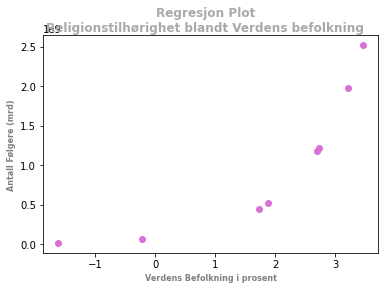

In [43]:
fig,ax=plt.subplots()
fig.suptitle('Regresjon Plot\nReligionstilhørighet blandt Verdens befolkning',
             fontsize = 12, fontweight ='bold', color = "darkgray")
#legger til axis_lables:
ax.set_ylabel('Antall Følgere (mrd)',
              fontsize = 8, fontweight='bold', color = "gray")
ax.set_xlabel('Verdens Befolkning i prosent',
              fontsize = 8, fontweight='bold', color = "gray")
#Farger til de forskjellige religioner

#plotter funksjonen:
ax.scatter(np.log(FolkogReligion['TotAvPopulasjonPros']), 
           FolkogReligion['AntallFølgere'], color = "orchid")
ax.legend(loc='upper left', frameon=False)

/tmp/ipykernel_11448/98250526.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)
/tmp/ipykernel_11448/98250526.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)


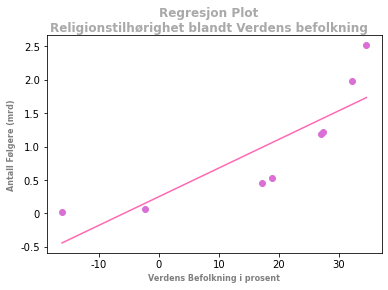

In [39]:
x=np.linspace(min(np.log(FolkogReligion['TotAvPopulasjonPros'])),
              max(np.log(FolkogReligion['TotAvPopulasjonPros'])), 200)

regresjons_linje=res.params['intercept']+res.params['TotAvPopulasjonPros']*x

ax.plot(x, regresjons_linje,color='hotpink')
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[1:5] = ['-10', '0','10','20','30']
ax.set_xticklabels(labels)
labels = [item.get_text() for item in ax.get_yticklabels()]
labels[1:5] = ['-0.5', '0','0.5','1.0','1.5','2.0','2.5']
ax.set_yticklabels(labels)

plt.show()
fig

In [42]:
res.params

TotAvPopulasjonPros    4.296245e+08
intercept              2.482423e+08
dtype: float64

Når tabellen omsider var på plass, ville jeg se på forholdet mellom Antall følgere av en religion mot verdens befolkning (%). Begynte med å  hente ut variabelen "AntallFølgere" og lagde en df av den kalt "y".
Deretter tok jeg logaritmen av den ønskede variabelen for "x". Når jeg hentet ut denne kolonnen, sørget jeg for å brukt np.log, og "intercept". Med "intercept"=1. Parameter TotAvPopulasjonPros=4.296245e+08 vil antyde at regresjonslina vil være stigende da det er et positivt tall.
Med bruk av OLS og .fit fra statmodels, la jeg x og y opp mot hverandre kalt res.
Når plottet skulle lages sørget jeg for at regresjonslinja ble korrekt ved å bruke np.linspace og logaritmen av den minste og største verdien. 
Deretter tok jeg, intercept:2.482423e+08 + TotAvPopulasjonPros4:296245e+08 * x(np.linspace).
Som på annen måte kan skrives som, a + b * ln(x)
Når jeg ser på grafen, har den en stigende regresjonslinje. Den estimerer en linær gjennomsnittlig linje gjennom punktene. En rask tolkning er for eksempel at av verdenspopulasjonen er det mest sansynlig at du tilhører kristen tro. Ser man på plasseringen av punktene rundt regresjonslinja er det ingen forhold som tilsier at det er gitt at du vil tilhøre en kristen tro, og av dette er det nærliggende å anta at hvordan religion en er følgere av, er tilfeldig. En avgjørende og vesentlig variabel som da ville endret denne grafen er hvor en er født, og hvilke religioner er mest "populære" i dette området.

OPPGAVE B)

Min oppfatning av denne oppgaven, og fra hva vi har lært om blotto,
var å fordele de 100 battalionene på 6 felter. Jeg har gjort nettopp dette, og med tanke på at du skulle lime min funksjon inn i en kamp på 100 000 omganger, har jeg ikke gjort noe mer enn å forsøke tenke sannsynlighet når jeg skrev inn mine tall. Spent på resultatet!

In [ ]:
def eov016_strategy(n_battalions,n_fields):
    
    battalions=np.zeros(n_fields,dtype=int)
    
    #Min plassering av battalioner:
    battalions[0:]=0
    battalions[1:]=31
    battalions[2:]=7
    battalions[3:]=0
    battalions[4:]=31
    battalions[5:]=31

    
    
    battalions=battalions[np.random.rand(n_fields).argsort()]
    assert sum(battalions)==n_battalions
    
    return battalions